In [43]:
import pandas as pd
import pypsa
import numpy as np
import matplotlib.pyplot as plt

# Load Data

In [44]:
# load electricity demand data
df_elec = pd.read_csv('data/electricity_demand.csv', sep=';', index_col=0) # in MWh
df_elec.index = pd.to_datetime(df_elec.index) #change index to datatime

# load onshore wind data
df_onshorewind = pd.read_csv('data/onshore_wind_1979-2017.csv', sep=';', index_col=0)
df_onshorewind.index = pd.to_datetime(df_onshorewind.index)

# load offshore wind data
df_offshorewind = pd.read_csv('data/offshore_wind_1979-2017.csv', sep=';', index_col=0)
df_offshorewind.index = pd.to_datetime(df_offshorewind.index)

# load large scale pv data
df_pv = pd.read_csv('data\pv_optimal.csv', sep=';', index_col=0)
df_pv.index = pd.to_datetime(df_pv.index)

# load rooftop pv data
df_rooftop = pd.read_csv('data\pv_rooftop.csv', sep=';', index_col=0)
df_rooftop.index = pd.to_datetime(df_rooftop.index)


<>:14: DeprecationWarning: invalid escape sequence '\p'
<>:18: DeprecationWarning: invalid escape sequence '\p'
<>:14: DeprecationWarning: invalid escape sequence '\p'
<>:18: DeprecationWarning: invalid escape sequence '\p'
C:\Users\alexk\AppData\Local\Temp\ipykernel_46188\3683553303.py:14: DeprecationWarning: invalid escape sequence '\p'
  df_pv = pd.read_csv('data\pv_optimal.csv', sep=';', index_col=0)
C:\Users\alexk\AppData\Local\Temp\ipykernel_46188\3683553303.py:18: DeprecationWarning: invalid escape sequence '\p'
  df_rooftop = pd.read_csv('data\pv_rooftop.csv', sep=';', index_col=0)


In [45]:
colors = {"onshore": "blue", "offshore": "darkblue", "pv": "orange", 
          "rooftop": "yellow", "coal": "brown", "OCGT": "grey"}

# Make Network

In [46]:
def annuity(n,r):
    """ Calculate the annuity factor for an asset with lifetime n years and
    discount rate  r """

    if r > 0:
        return r/(1. - 1./(1.+r)**n)
    else:
        return 1/n

In [47]:
n = pypsa.Network()
hours_in_2015 = pd.date_range('2015-01-01 00:00Z',
                              '2015-12-31 23:00Z',
                              freq='h')

n.set_snapshots(hours_in_2015.values)

# add the different carriers, only gas emits CO2
n.add("Carrier", "gas", co2_emissions=0.19) # in t_CO2/MWh_th
n.add("Carrier", "coal", co2_emissions=0.9) # in t_CO2/MWh_th
n.add("Carrier", "onshorewind")
n.add("Carrier", "offshorewind")
n.add("Carrier", "solarPV")
n.add("Carrier", "rooftopPV")
n.add("Carrier", "hydro")

countries = ['DEU', 'DNK', 'AUT']

# add electricity bus
for country in countries:
    n.add("Bus",
                f"E_bus{country}")

    # add load to the bus
    n.add("Load",
                f"load{country}",
                bus=f"E_bus{country}",
                p_set=df_elec[country].values)


    ''' Add renewable generators '''
    if country != 'AUT':
        # Add onshore wind
        CF_wind_onshore = df_onshorewind[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in n.snapshots]]
        lifetime = 30 # years
        discount_rate = 0.07 # 7%
        capex = 910000 # in €/MW
        fopex = 0.033 # 3.3% of capex
        capital_cost_onshorewind = annuity(lifetime,discount_rate)*capex*(1+fopex) # in €/MW
        n.add("Generator",
                    f"onshorewind{country}",
                    bus=f"E_bus{country}",
                    p_nom_extendable=True,
                    carrier="onshorewind",
                    #p_nom_max=1000, # maximum capacity can be limited due to environmental constraints
                    capital_cost = capital_cost_onshorewind,
                    marginal_cost = 0,
                    p_max_pu = CF_wind_onshore.values)

        # Add offshore wind
        CF_wind_offshore = df_offshorewind[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in n.snapshots]]
        lifetime = 25 # years
        discount_rate = 0.07 # 7%
        capex = 2506000 # in €/MW
        fopex = 0.03 # 3% of capex
        capital_cost_offshorewind = annuity(lifetime,discount_rate)*capex*(1+fopex) # in €/MW
        n.add("Generator",
                    f"offshorewind{country}",
                    bus=f"E_bus{country}",
                    p_nom_extendable=True,
                    carrier="offshorewind",
                    #p_nom_max=1000, # maximum capacity can be limited due to environmental constraints
                    capital_cost = capital_cost_offshorewind,
                    marginal_cost = 0,
                    p_max_pu = CF_wind_offshore.values)

    # Add large scale solar
    CF_solar = df_pv[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in n.snapshots]]
    lifetime = 25 # years
    discount_rate = 0.07 # 7%
    capex = 425000 # in €/MW
    fopex = 0.03 # 3% of capex
    capital_cost_pv = annuity(lifetime,discount_rate)*capex*(1+fopex) # in €/MW
    n.add("Generator",
                f"PV{country}",
                bus=f"E_bus{country}",
                p_nom_extendable=True,
                carrier="solarPV",
                #p_nom_max=1000, # maximum capacity can be limited due to environmental constraints
                capital_cost = capital_cost_pv,
                marginal_cost = 0,
                p_max_pu = CF_solar.values)

    # Add rooftop solar
    CF_rooftop = df_rooftop[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in n.snapshots]]
    lifetime = 25 # years
    discount_rate = 0.07 # 7%
    capex = 725000 # in €/MW
    fopex = 0.02 # 2% of capex
    capital_cost_rooftop = annuity(lifetime,discount_rate)*capex*(1+fopex) # in €/MW
    n.add("Generator",
                f"rooftopPV{country}",
                bus=f"E_bus{country}",
                p_nom_extendable=True,
                carrier="rooftopPV",
                #p_nom_max=1000, # maximum capacity can be limited due to environmental constraints
                capital_cost = capital_cost_rooftop,
                marginal_cost = 0,
                p_max_pu = CF_rooftop.values)

    ''' Add non-renewables generators '''
    # add OCGT (Open Cycle Gas Turbine) generator
    lifetime = 25 # years
    discount_rate = 0.07 # 7%
    capex = 560000 # in €/MW
    fopex = 0.033 # 3.3% of capex
    capital_cost_OCGT = annuity(lifetime,discount_rate)*capex*(1+fopex) # in €/MW
    fuel_cost = 21.6 # in €/MWh_th
    efficiency = 0.39 # MWh_elec/MWh_th
    marginal_cost_OCGT = fuel_cost/efficiency # in €/MWh_el
    n.add("Generator",
                f"OCGT{country}",
                bus=f"E_bus{country}",
                p_nom_extendable=True,
                carrier="gas",
                #p_nom_max=1000,
                capital_cost = capital_cost_OCGT,
                efficiency = efficiency,
                marginal_cost = marginal_cost_OCGT)

    if country == 'DEU':
        # add coal generator (without CCS) # https://atb-archive.nrel.gov/electricity/2018/index.html?t=cc
        lifetime = 25 # years
        discount_rate = 0.07 # 7%
        capex = 3294000 # in €/MW
        fopex = 0.03 # 3% of capex
        capital_cost_coal = annuity(lifetime,discount_rate)*capex*(1+fopex) # in €/MW
        fuel_cost = 4 # in €/MWh_th 
        efficiency = 0.36 # MWh_elec/MWh_th
        marginal_cost_coal = fuel_cost/efficiency # in €/MWh_el
        n.add("Generator",
                    f"coal{country}",
                    bus=f"E_bus{country}",
                    p_nom_extendable=True,
                    carrier="coal",
                    #p_nom_max=1000,
                    capital_cost = capital_cost_coal,
                    efficiency = efficiency,
                    marginal_cost = marginal_cost_coal)
        
    if country == 'AUT':
        lifetime = 80 # years
        discount_rate = 0.07 # 7%
        capex = 300000 # in €/MW
        fopex = 0.02 # 2% of capex
        capital_cost_coal = annuity(lifetime,discount_rate)*capex*(1+fopex) # in €/MW
        marginal_cost_coal = 0
        n.add("Generator",
                    f"hydro{country}",
                    bus=f"E_bus{country}",
                    p_nom_extendable=True,
                    carrier="hydro",
                    p_nom_max=5000,
                    capital_cost = capital_cost_coal,
                    marginal_cost = marginal_cost_coal)
        


'''
    # Add storage unit
    n.add("StorageUnit",
                f"battery{country}",
                bus=f"E_bus{country}",
                p_nom_extendable=True,
                capital_cost=12894+24678,
                efficiency_dispatch=0.96,
                efficiency_store=0.96,
                max_hours=2,
                cyclic_state_of_charge=True)
    


'''

'\n    # Add storage unit\n    n.add("StorageUnit",\n                f"battery{country}",\n                bus=f"E_bus{country}",\n                p_nom_extendable=True,\n                capital_cost=12894+24678,\n                efficiency_dispatch=0.96,\n                efficiency_store=0.96,\n                max_hours=2,\n                cyclic_state_of_charge=True)\n    \n\n\n'

In [48]:
# Add the links between the countries
n.add("Link",
            "linkDEU-DNK",
            bus0="E_busDEU",
            bus1="E_busDNK",
            p_nom_extendable=True,
            p_min_pu=-1,
            length=200,
            capital_cost=400*200) # capital cost * length

n.add("Link",
            "linkDEU-AUT",
            bus0="E_busDEU",
            bus1="E_busAUT",
            p_nom_extendable=True,
            p_min_pu=-1,
            length=100,
            capital_cost=400*100) # capital cost * length

n.add("Link",
            "linkDNK-AUT",
            bus0="E_busDNK",
            bus1="E_busAUT",
            p_nom_extendable=True,
            p_min_pu=-1,
            length=210,
            capital_cost=400*210) # capital cost * length


Index(['linkDNK-AUT'], dtype='object')

In [49]:
# Co2 Cap
n.add(
    "GlobalConstraint",
    "CO2Limit",
    carrier_attribute="co2_emissions",
    sense="<=",
    constant=(596 + 27.3 + 58.6) * 1000000, #596MtCO2 for GE + 4.6 for DK + 6.4 for AT
)

Index(['CO2Limit'], dtype='object')

In [50]:
n.optimize(solver_name='gurobi')

Index(['E_busDEU', 'E_busDNK', 'E_busAUT'], dtype='object', name='Bus')
Index(['linkDEU-DNK', 'linkDEU-AUT', 'linkDNK-AUT'], dtype='object', name='Link')


INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00, 11.58it/s]
INFO:linopy.io: Writing time: 2.51s


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-09-04


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-09-04


Read LP format model from file C:\Users\alexk\AppData\Local\Temp\linopy-problem-oyjbv7v6.lp


INFO:gurobipy:Read LP format model from file C:\Users\alexk\AppData\Local\Temp\linopy-problem-oyjbv7v6.lp


Reading time = 0.84 seconds


INFO:gurobipy:Reading time = 0.84 seconds


obj: 341660 rows, 157698 columns, 692522 nonzeros


INFO:gurobipy:obj: 341660 rows, 157698 columns, 692522 nonzeros


Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))


INFO:gurobipy:


CPU model: AMD Ryzen 5 4600H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 5 4600H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 6 physical cores, 12 logical processors, using up to 12 threads


INFO:gurobipy:Thread count: 6 physical cores, 12 logical processors, using up to 12 threads


INFO:gurobipy:


Optimize a model with 341660 rows, 157698 columns and 692522 nonzeros


INFO:gurobipy:Optimize a model with 341660 rows, 157698 columns and 692522 nonzeros


Model fingerprint: 0xfbdfb690


INFO:gurobipy:Model fingerprint: 0xfbdfb690


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 3e+00]


INFO:gurobipy:  Matrix range     [1e-03, 3e+00]


  Objective range  [1e+01, 3e+05]


INFO:gurobipy:  Objective range  [1e+01, 3e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 7e+08]


INFO:gurobipy:  RHS range        [2e+03, 7e+08]


Presolve removed 183516 rows and 43337 columns


INFO:gurobipy:Presolve removed 183516 rows and 43337 columns


Presolve time: 0.64s


INFO:gurobipy:Presolve time: 0.64s


Presolved: 158144 rows, 114361 columns, 622411 nonzeros


INFO:gurobipy:Presolved: 158144 rows, 114361 columns, 622411 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.08s


INFO:gurobipy:Ordering time: 0.08s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 18


INFO:gurobipy: Dense cols : 18


 AA' NZ     : 6.395e+05


INFO:gurobipy: AA' NZ     : 6.395e+05


 Factor NZ  : 2.754e+06 (roughly 130 MB of memory)


INFO:gurobipy: Factor NZ  : 2.754e+06 (roughly 130 MB of memory)


 Factor Ops : 5.012e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 5.012e+07 (less than 1 second per iteration)


 Threads    : 4


INFO:gurobipy: Threads    : 4


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   2.17574737e+13  3.70630607e+10  7.71e+10 3.70e+01  2.03e+10     1s


INFO:gurobipy:   0   2.17574737e+13  3.70630607e+10  7.71e+10 3.70e+01  2.03e+10     1s


   1   2.64463447e+13 -5.73577778e+12  5.21e+10 1.05e+03  8.80e+09     1s


INFO:gurobipy:   1   2.64463447e+13 -5.73577778e+12  5.21e+10 1.05e+03  8.80e+09     1s


   2   2.90554223e+13 -6.46543404e+12  4.30e+10 2.14e+02  6.03e+09     2s


INFO:gurobipy:   2   2.90554223e+13 -6.46543404e+12  4.30e+10 2.14e+02  6.03e+09     2s


   3   2.69123389e+13 -6.65570857e+12  8.65e+08 6.55e+00  2.12e+08     2s


INFO:gurobipy:   3   2.69123389e+13 -6.65570857e+12  8.65e+08 6.55e+00  2.12e+08     2s


   4   2.10671562e+12 -4.46266209e+12  2.57e+07 2.06e+00  2.22e+07     2s


INFO:gurobipy:   4   2.10671562e+12 -4.46266209e+12  2.57e+07 2.06e+00  2.22e+07     2s


   5   9.42724273e+11 -2.30423176e+12  4.74e+03 8.26e-01  9.61e+06     2s


INFO:gurobipy:   5   9.42724273e+11 -2.30423176e+12  4.74e+03 8.26e-01  9.61e+06     2s


   6   3.55390230e+11 -4.58312233e+11  1.26e+03 1.07e-07  2.26e+06     2s


INFO:gurobipy:   6   3.55390230e+11 -4.58312233e+11  1.26e+03 1.07e-07  2.26e+06     2s


   7   1.64726069e+11 -8.48121032e+10  4.84e+02 2.42e-08  6.83e+05     3s


INFO:gurobipy:   7   1.64726069e+11 -8.48121032e+10  4.84e+02 2.42e-08  6.83e+05     3s


   8   8.72106058e+10 -2.12986257e+10  2.04e+02 1.36e-08  2.96e+05     3s


INFO:gurobipy:   8   8.72106058e+10 -2.12986257e+10  2.04e+02 1.36e-08  2.96e+05     3s


   9   6.59088912e+10 -2.54195959e+08  1.36e+02 1.69e-09  1.80e+05     3s


INFO:gurobipy:   9   6.59088912e+10 -2.54195959e+08  1.36e+02 1.69e-09  1.80e+05     3s


  10   5.62485703e+10  4.28620600e+09  1.04e+02 1.75e-09  1.41e+05     3s


INFO:gurobipy:  10   5.62485703e+10  4.28620600e+09  1.04e+02 1.75e-09  1.41e+05     3s


  11   4.84708238e+10  1.12002338e+10  7.58e+01 5.53e-10  1.01e+05     3s


INFO:gurobipy:  11   4.84708238e+10  1.12002338e+10  7.58e+01 5.53e-10  1.01e+05     3s


  12   4.37127717e+10  1.73813499e+10  5.54e+01 2.91e-11  7.16e+04     4s


INFO:gurobipy:  12   4.37127717e+10  1.73813499e+10  5.54e+01 2.91e-11  7.16e+04     4s


  13   4.08769326e+10  2.33475465e+10  4.51e+01 2.04e-10  4.76e+04     4s


INFO:gurobipy:  13   4.08769326e+10  2.33475465e+10  4.51e+01 2.04e-10  4.76e+04     4s


  14   3.40044694e+10  2.54744229e+10  1.77e+01 1.66e-09  2.32e+04     4s


INFO:gurobipy:  14   3.40044694e+10  2.54744229e+10  1.77e+01 1.66e-09  2.32e+04     4s


  15   3.25710394e+10  2.71790124e+10  1.24e+01 1.75e-09  1.46e+04     4s


INFO:gurobipy:  15   3.25710394e+10  2.71790124e+10  1.24e+01 1.75e-09  1.46e+04     4s


  16   3.21716062e+10  2.76573676e+10  1.09e+01 2.27e-09  1.23e+04     4s


INFO:gurobipy:  16   3.21716062e+10  2.76573676e+10  1.09e+01 2.27e-09  1.23e+04     4s


  17   3.10199164e+10  2.80677863e+10  6.92e+00 3.81e-09  8.01e+03     5s


INFO:gurobipy:  17   3.10199164e+10  2.80677863e+10  6.92e+00 3.81e-09  8.01e+03     5s


  18   3.03893744e+10  2.82809286e+10  4.86e+00 9.02e-10  5.72e+03     5s


INFO:gurobipy:  18   3.03893744e+10  2.82809286e+10  4.86e+00 9.02e-10  5.72e+03     5s


  19   2.98655529e+10  2.84583440e+10  3.18e+00 0.00e+00  3.82e+03     5s


INFO:gurobipy:  19   2.98655529e+10  2.84583440e+10  3.18e+00 0.00e+00  3.82e+03     5s


  20   2.97143565e+10  2.85717694e+10  2.69e+00 1.37e-09  3.10e+03     6s


INFO:gurobipy:  20   2.97143565e+10  2.85717694e+10  2.69e+00 1.37e-09  3.10e+03     6s


  21   2.95703295e+10  2.86019470e+10  2.23e+00 7.28e-10  2.63e+03     6s


INFO:gurobipy:  21   2.95703295e+10  2.86019470e+10  2.23e+00 7.28e-10  2.63e+03     6s


  22   2.94897118e+10  2.86165851e+10  1.95e+00 0.00e+00  2.37e+03     6s


INFO:gurobipy:  22   2.94897118e+10  2.86165851e+10  1.95e+00 0.00e+00  2.37e+03     6s


  23   2.93838918e+10  2.86932149e+10  1.59e+00 1.54e-09  1.87e+03     7s


INFO:gurobipy:  23   2.93838918e+10  2.86932149e+10  1.59e+00 1.54e-09  1.87e+03     7s


  24   2.92979103e+10  2.87563695e+10  1.29e+00 1.46e-09  1.47e+03     7s


INFO:gurobipy:  24   2.92979103e+10  2.87563695e+10  1.29e+00 1.46e-09  1.47e+03     7s


  25   2.92496322e+10  2.87965009e+10  1.12e+00 1.57e-09  1.23e+03     7s


INFO:gurobipy:  25   2.92496322e+10  2.87965009e+10  1.12e+00 1.57e-09  1.23e+03     7s


  26   2.91922416e+10  2.88372404e+10  8.89e-01 0.00e+00  9.64e+02     8s


INFO:gurobipy:  26   2.91922416e+10  2.88372404e+10  8.89e-01 0.00e+00  9.64e+02     8s


  27   2.91319302e+10  2.88706436e+10  6.53e-01 1.25e-09  7.09e+02     8s


INFO:gurobipy:  27   2.91319302e+10  2.88706436e+10  6.53e-01 1.25e-09  7.09e+02     8s


  28   2.91009016e+10  2.88978444e+10  5.27e-01 1.31e-09  5.51e+02     8s


INFO:gurobipy:  28   2.91009016e+10  2.88978444e+10  5.27e-01 1.31e-09  5.51e+02     8s


  29   2.90755899e+10  2.89084817e+10  4.22e-01 0.00e+00  4.54e+02     9s


INFO:gurobipy:  29   2.90755899e+10  2.89084817e+10  4.22e-01 0.00e+00  4.54e+02     9s


  30   2.90528661e+10  2.89250060e+10  3.26e-01 0.00e+00  3.47e+02     9s


INFO:gurobipy:  30   2.90528661e+10  2.89250060e+10  3.26e-01 0.00e+00  3.47e+02     9s


  31   2.90399354e+10  2.89359166e+10  2.74e-01 0.00e+00  2.82e+02     9s


INFO:gurobipy:  31   2.90399354e+10  2.89359166e+10  2.74e-01 0.00e+00  2.82e+02     9s


  32   2.90245545e+10  2.89447956e+10  2.09e-01 6.11e-10  2.16e+02    10s


INFO:gurobipy:  32   2.90245545e+10  2.89447956e+10  2.09e-01 6.11e-10  2.16e+02    10s


  33   2.90154076e+10  2.89498836e+10  1.69e-01 3.35e-09  1.78e+02    10s


INFO:gurobipy:  33   2.90154076e+10  2.89498836e+10  1.69e-01 3.35e-09  1.78e+02    10s


  34   2.90090586e+10  2.89537389e+10  1.41e-01 2.97e-09  1.50e+02    10s


INFO:gurobipy:  34   2.90090586e+10  2.89537389e+10  1.41e-01 2.97e-09  1.50e+02    10s


  35   2.90008327e+10  2.89596674e+10  1.07e-01 6.40e-10  1.12e+02    11s


INFO:gurobipy:  35   2.90008327e+10  2.89596674e+10  1.07e-01 6.40e-10  1.12e+02    11s


  36   2.89965359e+10  2.89636740e+10  8.88e-02 0.00e+00  8.92e+01    11s


INFO:gurobipy:  36   2.89965359e+10  2.89636740e+10  8.88e-02 0.00e+00  8.92e+01    11s


  37   2.89925964e+10  2.89667236e+10  7.14e-02 0.00e+00  7.02e+01    11s


INFO:gurobipy:  37   2.89925964e+10  2.89667236e+10  7.14e-02 0.00e+00  7.02e+01    11s


  38   2.89886471e+10  2.89689542e+10  5.38e-02 0.00e+00  5.35e+01    12s


INFO:gurobipy:  38   2.89886471e+10  2.89689542e+10  5.38e-02 0.00e+00  5.35e+01    12s


  39   2.89862766e+10  2.89704291e+10  4.40e-02 0.00e+00  4.30e+01    12s


INFO:gurobipy:  39   2.89862766e+10  2.89704291e+10  4.40e-02 0.00e+00  4.30e+01    12s


  40   2.89832306e+10  2.89718614e+10  3.02e-02 0.00e+00  3.09e+01    12s


INFO:gurobipy:  40   2.89832306e+10  2.89718614e+10  3.02e-02 0.00e+00  3.09e+01    12s


  41   2.89811368e+10  2.89729374e+10  2.04e-02 0.00e+00  2.23e+01    13s


INFO:gurobipy:  41   2.89811368e+10  2.89729374e+10  2.04e-02 0.00e+00  2.23e+01    13s


  42   2.89802669e+10  2.89739819e+10  1.63e-02 0.00e+00  1.71e+01    13s


INFO:gurobipy:  42   2.89802669e+10  2.89739819e+10  1.63e-02 0.00e+00  1.71e+01    13s


  43   2.89795198e+10  2.89744887e+10  1.29e-02 0.00e+00  1.37e+01    14s


INFO:gurobipy:  43   2.89795198e+10  2.89744887e+10  1.29e-02 0.00e+00  1.37e+01    14s


  44   2.89789314e+10  2.89750857e+10  1.03e-02 0.00e+00  1.04e+01    14s


INFO:gurobipy:  44   2.89789314e+10  2.89750857e+10  1.03e-02 0.00e+00  1.04e+01    14s


  45   2.89779444e+10  2.89756471e+10  5.64e-03 0.00e+00  6.23e+00    14s


INFO:gurobipy:  45   2.89779444e+10  2.89756471e+10  5.64e-03 0.00e+00  6.23e+00    14s


  46   2.89774869e+10  2.89763033e+10  3.49e-03 0.00e+00  3.21e+00    15s


INFO:gurobipy:  46   2.89774869e+10  2.89763033e+10  3.49e-03 0.00e+00  3.21e+00    15s


  47   2.89768990e+10  2.89764839e+10  7.64e-04 0.00e+00  1.13e+00    15s


INFO:gurobipy:  47   2.89768990e+10  2.89764839e+10  7.64e-04 0.00e+00  1.13e+00    15s


  48   2.89768076e+10  2.89765797e+10  3.49e-04 8.86e-08  6.18e-01    15s


INFO:gurobipy:  48   2.89768076e+10  2.89765797e+10  3.49e-04 8.86e-08  6.18e-01    15s


  49   2.89767479e+10  2.89766784e+10  8.97e-05 3.57e-08  1.88e-01    16s


INFO:gurobipy:  49   2.89767479e+10  2.89766784e+10  8.97e-05 3.57e-08  1.88e-01    16s


  50   2.89767297e+10  2.89767253e+10  1.63e-05 1.18e-07  1.21e-02    16s


INFO:gurobipy:  50   2.89767297e+10  2.89767253e+10  1.63e-05 1.18e-07  1.21e-02    16s


  51   2.89767266e+10  2.89767266e+10  5.11e-06 1.84e-08  1.35e-04    16s


INFO:gurobipy:  51   2.89767266e+10  2.89767266e+10  5.11e-06 1.84e-08  1.35e-04    16s


  52   2.89767266e+10  2.89767266e+10  5.37e-06 3.84e-08  3.55e-09    16s


INFO:gurobipy:  52   2.89767266e+10  2.89767266e+10  5.37e-06 3.84e-08  3.55e-09    16s


INFO:gurobipy:


Barrier solved model in 52 iterations and 16.28 seconds (4.28 work units)


INFO:gurobipy:Barrier solved model in 52 iterations and 16.28 seconds (4.28 work units)


Optimal objective 2.89767266e+10


INFO:gurobipy:Optimal objective 2.89767266e+10


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   30962 DPushes remaining with DInf 0.0000000e+00                17s


INFO:gurobipy:   30962 DPushes remaining with DInf 0.0000000e+00                17s


       0 DPushes remaining with DInf 0.0000000e+00                20s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                20s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


   18009 PPushes remaining with PInf 4.6106286e-03                20s


INFO:gurobipy:   18009 PPushes remaining with PInf 4.6106286e-03                20s


   14361 PPushes remaining with PInf 3.5590399e-06                36s


INFO:gurobipy:   14361 PPushes remaining with PInf 3.5590399e-06                36s


   12837 PPushes remaining with PInf 3.5590424e-06                40s


INFO:gurobipy:   12837 PPushes remaining with PInf 3.5590424e-06                40s


   11823 PPushes remaining with PInf 3.5590674e-06                46s


INFO:gurobipy:   11823 PPushes remaining with PInf 3.5590674e-06                46s


   11061 PPushes remaining with PInf 3.5590799e-06                50s


INFO:gurobipy:   11061 PPushes remaining with PInf 3.5590799e-06                50s


    9939 PPushes remaining with PInf 3.5590622e-06                56s


INFO:gurobipy:    9939 PPushes remaining with PInf 3.5590622e-06                56s


    9088 PPushes remaining with PInf 3.5590385e-06                61s


INFO:gurobipy:    9088 PPushes remaining with PInf 3.5590385e-06                61s


    8199 PPushes remaining with PInf 3.5590622e-06                67s


INFO:gurobipy:    8199 PPushes remaining with PInf 3.5590622e-06                67s


    7637 PPushes remaining with PInf 3.5590567e-06                71s


INFO:gurobipy:    7637 PPushes remaining with PInf 3.5590567e-06                71s


    6809 PPushes remaining with PInf 3.5590126e-06                76s


INFO:gurobipy:    6809 PPushes remaining with PInf 3.5590126e-06                76s


    6299 PPushes remaining with PInf 0.0000000e+00                80s


INFO:gurobipy:    6299 PPushes remaining with PInf 0.0000000e+00                80s


    5755 PPushes remaining with PInf 0.0000000e+00                85s


INFO:gurobipy:    5755 PPushes remaining with PInf 0.0000000e+00                85s


    4968 PPushes remaining with PInf 0.0000000e+00                92s


INFO:gurobipy:    4968 PPushes remaining with PInf 0.0000000e+00                92s


    4448 PPushes remaining with PInf 0.0000000e+00                97s


INFO:gurobipy:    4448 PPushes remaining with PInf 0.0000000e+00                97s


    3949 PPushes remaining with PInf 0.0000000e+00               102s


INFO:gurobipy:    3949 PPushes remaining with PInf 0.0000000e+00               102s


    3711 PPushes remaining with PInf 0.0000000e+00               105s


INFO:gurobipy:    3711 PPushes remaining with PInf 0.0000000e+00               105s


    3230 PPushes remaining with PInf 0.0000000e+00               110s


INFO:gurobipy:    3230 PPushes remaining with PInf 0.0000000e+00               110s


    2571 PPushes remaining with PInf 0.0000000e+00               115s


INFO:gurobipy:    2571 PPushes remaining with PInf 0.0000000e+00               115s


    1930 PPushes remaining with PInf 0.0000000e+00               121s


INFO:gurobipy:    1930 PPushes remaining with PInf 0.0000000e+00               121s


    1192 PPushes remaining with PInf 0.0000000e+00               126s


INFO:gurobipy:    1192 PPushes remaining with PInf 0.0000000e+00               126s


     554 PPushes remaining with PInf 0.0000000e+00               130s


INFO:gurobipy:     554 PPushes remaining with PInf 0.0000000e+00               130s


       0 PPushes remaining with PInf 0.0000000e+00               136s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00               136s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 2.8282452e-08    136s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 2.8282452e-08    136s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 1


INFO:gurobipy:Extra simplex iterations after uncrush: 1


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   45660    2.8976727e+10   0.000000e+00   0.000000e+00    140s


INFO:gurobipy:   45660    2.8976727e+10   0.000000e+00   0.000000e+00    140s


INFO:gurobipy:


Solved in 45660 iterations and 139.91 seconds (108.25 work units)


INFO:gurobipy:Solved in 45660 iterations and 139.91 seconds (108.25 work units)


Optimal objective  2.897672656e+10


INFO:gurobipy:Optimal objective  2.897672656e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 157698 primals, 341660 duals
Objective: 2.90e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.


('ok', 'optimal')

In [51]:
n.generators_t.p.columns

Index(['onshorewindDEU', 'offshorewindDEU', 'PVDEU', 'rooftopPVDEU', 'OCGTDEU',
       'coalDEU', 'onshorewindDNK', 'offshorewindDNK', 'PVDNK', 'rooftopPVDNK',
       'OCGTDNK', 'PVAUT', 'rooftopPVAUT', 'OCGTAUT', 'hydroAUT'],
      dtype='object', name='Generator')

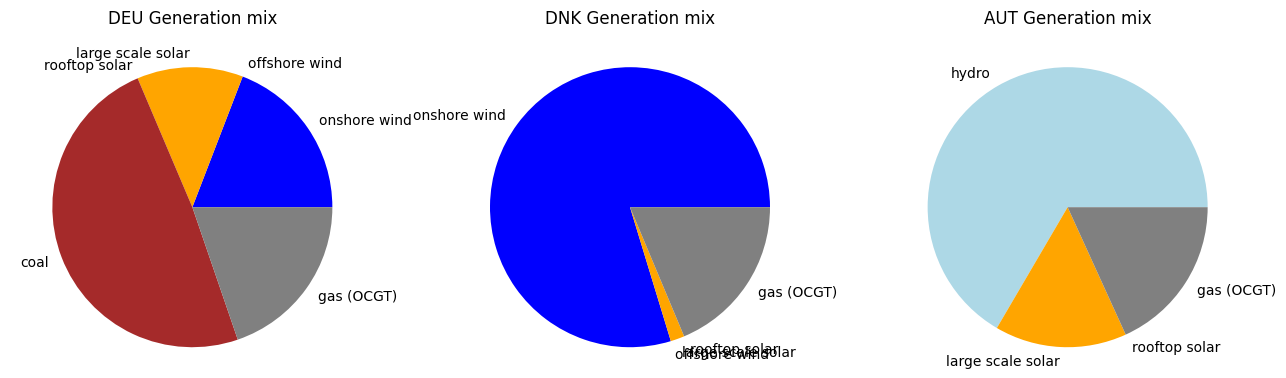

In [52]:
plt.figure(figsize=(16, 4))

for country in countries:      
   if country == "DEU":
      labels = ['onshore wind',
               'offshore wind',
               'large scale solar',
               'rooftop solar',
               'coal',
               'gas (OCGT)']
      sizes = [n.generators_t.p[f'onshorewind{country}'].sum(),
                     n.generators_t.p[f'offshorewind{country}'].sum(),
                  n.generators_t.p[f'PV{country}'].sum(),
                     n.generators_t.p[f'rooftopPV{country}'].sum(),
                     n.generators_t.p[f'coal{country}'].sum(),
                  n.generators_t.p[f'OCGT{country}'].sum()]

   

      colors=['blue', 'darkblue', 'orange', 'yellow', 'brown', 'grey']

      plt.subplot(1, 3, 1)
      plt.pie(sizes,
            colors=colors,
            labels=labels,
            wedgeprops={'linewidth':0})
      plt.axis('equal')

      plt.title(f'{country} Generation mix', y=1.07)
   
   if country == "DNK":
      labels = ['onshore wind',
               'offshore wind',
               'large scale solar',
               'rooftop solar',
               'gas (OCGT)']
      sizes = [n.generators_t.p[f'onshorewind{country}'].sum(),
                     n.generators_t.p[f'offshorewind{country}'].sum(),
                  n.generators_t.p[f'PV{country}'].sum(),
                     n.generators_t.p[f'rooftopPV{country}'].sum(),
                  n.generators_t.p[f'OCGT{country}'].sum()]

   

      colors=['blue', 'darkblue', 'orange', 'yellow', 'grey']

      plt.subplot(1, 3, 2)
      plt.pie(sizes,
            colors=colors,
            labels=labels,
            wedgeprops={'linewidth':0})
      plt.axis('equal')

      plt.title(f'{country} Generation mix', y=1.07)

   
   if country == "AUT":
      labels = ['hydro',
               'large scale solar',
               'rooftop solar',
               'gas (OCGT)']
      sizes = [n.generators_t.p[f'hydro{country}'].sum(),
                  n.generators_t.p[f'PV{country}'].sum(),
                     n.generators_t.p[f'rooftopPV{country}'].sum(),
                  n.generators_t.p[f'OCGT{country}'].sum()]

   

      colors=['lightblue', 'orange', 'yellow', 'grey']

      plt.subplot(1, 3, 3)
      plt.pie(sizes,
            colors=colors,
            labels=labels,
            wedgeprops={'linewidth':0})
      plt.axis('equal')

      plt.title(f'{country} Generation mix', y=1.07)

      


<AxesSubplot: xlabel='snapshot', ylabel='dispatch'>

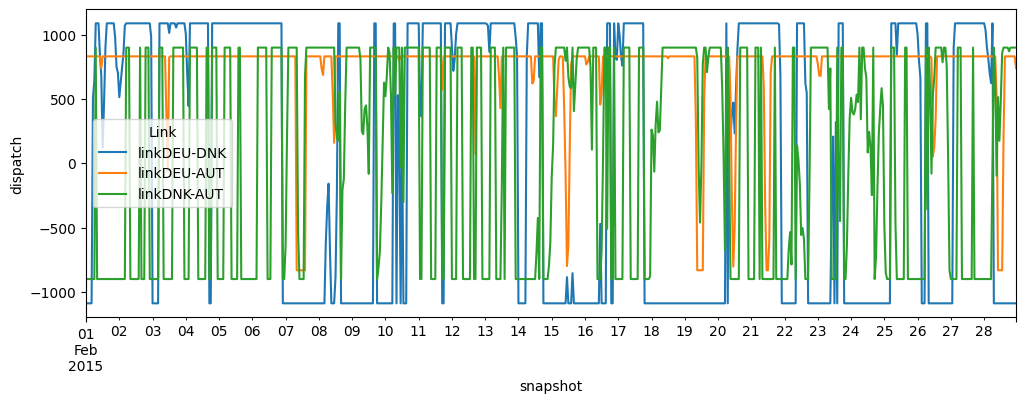

In [53]:
n.links_t.p0.loc["2015-02"].plot(figsize=(12, 4), ylabel="dispatch")

In [54]:
n.links_t.p0

Link,linkDEU-DNK,linkDEU-AUT,linkDNK-AUT
snapshot,,,
2015-01-01 00:00:00,-1088.703495,831.789433,671.425334
2015-01-01 01:00:00,-1088.703495,764.580874,836.419126
2015-01-01 02:00:00,-1088.703495,411.047792,899.952208
2015-01-01 03:00:00,-1088.703495,330.047792,899.952208
2015-01-01 04:00:00,-1088.703495,421.047792,899.952208
...,...,...,...
2015-12-31 19:00:00,907.541844,831.789433,-899.952208
2015-12-31 20:00:00,1068.617835,831.789433,-899.952208
2015-12-31 21:00:00,965.554868,831.789433,-899.952208
